In [1]:
from gurobipy import*
import pandas as pd
from plotnine import *

# initiation

m               = Model('case2')
demandFile      = pd.read_csv("Demand.csv", header=None)
minDemandFile   = pd.read_csv("minRequire.csv", header=None)
shiftTime       = pd.read_csv("shiftTime.csv", header = None)

# parameter
s   = [ i for i in range(14)]                                              # shift
t   = [ i for i in range(31)]                                              # day
p   = [ i for i in range(24)]                                              # period
D   = [ row.tolist() for index, row in demandFile.iterrows() ]             # demand 
Mt  = minDemandFile.iloc[:,0].tolist()                                     # requested shift, min demend, day
Ms  = minDemandFile.iloc[:,1].tolist()                                     # shift
M   = minDemandFile.iloc[:,2].tolist()                                     # number
T   = [ row.tolist() for index, row in shiftTime.iterrows() ]              # shift period

# for question 4
emplo_num = pd.DataFrame(columns = ('emploNum' , 's0_equal', 'sNight_max', 'sAfn_max','obj'))
for i in range(35,46):
    diff_emplo = pd.Series({'emploNum'       :i,
                            's0_equal'       :int(8*i),
                            'sNight_max'     :int(31/7*i),
                            'sAfn_max'       :int(31/7*i)*2,
                            'obj'            :0})
    emplo_num = emplo_num.append(diff_emplo,ignore_index=True)

#for question 4
result    = []




--------------------------------------------
--------------------------------------------

Using license file /Users/evaliao/gurobi.lic
Academic license - for non-commercial use only


In [2]:
# with diff emplo

for index,row in emplo_num.iterrows() :
    
    # variable
    X         = m.addVars(len(s), len(t), name = "ActualShift")
    W         = m.addVars(len(p), len(t), name = "ObjectiveFunction")

    m.update()

    # objective function

    obj       = quicksum(W[i,j] for i in range(len(p)) for j in range(len(t)))
    m.setObjective(obj, GRB.MINIMIZE)
    
    # constraint 
    
    for i in range(len(t)):
        m.addConstr(quicksum(X[j,i] for j in range(len(s))) == row['emploNum'])                                   # every day emplo ==40


    for i in range(len(p)):                                                                                       # objective function
        for j in range(len(t)):
            m.addConstr(W[i,j] >= D[i][j] - quicksum(X[z,j]*T[z][i] for z in range(len(s))))
            m.addConstr(W[i,j] >= 0)


    m.addConstr(quicksum(X[0,i] for i in range(len(t))) == row['s0_equal'])                                       # shift 0 = 320

    for i in range(len(Mt)):                                                                                      # shift request
        m.addConstr(X[Ms[i],Mt[i]] >= M[i])


    m.addConstr(quicksum(X[shift,day] for day in range(len(t)) for shift in range(11,14)) <= row['sNight_max'])   # night shift <=177
    m.addConstr(quicksum(X[shift,day] for day in range(len(t)) for shift in range(7,11)) <= row['sAfn_max'])      # afternoon shift <=354


    for i in range(len(t)-6):
        m.addConstr(quicksum(X[0,day] for day in range(i,i+6)) >= row['emploNum'])                                # no 7 consect day work

    # optimize
    m.optimize()
    emplo_num.iloc[index,4] = int(m.objVal)
    
    
    # print if employee = 40
    
    if(row['emploNum'] == 40):
        result40 = list()
        for v in m.getVars():
            result40 = result40.append(v.x)
            
        actualS = [list() for i in range(14)] 
        for i in range(14):
            for j in range(31):
                actualS[i] = actualS[i].append(v.x)
            
        import xlsxwriter
        with xlsxwriter.Workbook('actualS_40emplo.xlsx') as workbook:
            worksheet = workbook.add_worksheet()
            for row_num, data in enumerate(actualS):
                worksheet.write_row(row_num, 0, data)



Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 1558 rows, 1178 columns and 8469 nonzeros
Model fingerprint: 0x710d5d6e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 755 rows and 0 columns
Presolve time: 0.01s
Presolved: 803 rows, 1178 columns, 7714 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.986750e+03   0.000000e+00      0s
     939    3.5300000e+02   0.000000e+00   0.000000e+00      0s

Solved in 939 iterations and 0.09 seconds
Optimal objective  3.530000000e+02
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 3116 rows, 2356 columns and 16938 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Iteration    Objective       P

AttributeError: 'NoneType' object has no attribute 'append'

In [50]:
emplo_num

,emploNum,s0_equal,sNight_max,sAfn_max,obj
0,35,280,155,310,353
1,36,288,159,318,333
2,37,296,163,326,313
3,38,304,168,336,288
4,39,312,172,344,268
5,40,320,177,354,243
6,41,328,181,362,223
7,42,336,186,372,198
8,43,344,190,380,178
9,44,352,194,388,158


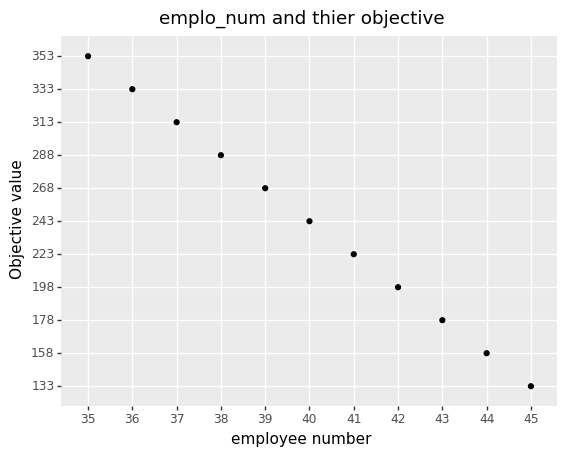

<ggplot: (295441065)>

In [51]:


(ggplot(emplo_num, aes(x ='emploNum', y = 'obj'))
 + geom_point()
 + stat_smooth(method='lm')
 + labs(title='emplo_num and thier objective', x='employee number', y='Objective value')
)


In [33]:
import xlsxwriter

In [34]:
with xlsxwriter.Workbook('actualS.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(actualS):
        worksheet.write_row(row_num, 0, data)


In [35]:
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

ActualShift[0,0] 8
ActualShift[0,1] 15
ActualShift[0,2] 16.5
ActualShift[0,3] 9.5
ActualShift[0,4] 15
ActualShift[0,5] 16.5
ActualShift[0,6] 17
ActualShift[0,7] 10
ActualShift[0,8] 15
ActualShift[0,9] 13
ActualShift[0,10] 12.5
ActualShift[0,11] 14
ActualShift[0,12] 5
ActualShift[0,13] 1
ActualShift[0,14] 1
ActualShift[0,15] 0
ActualShift[0,16] 8
ActualShift[0,17] 11
ActualShift[0,18] 15
ActualShift[0,19] 8
ActualShift[0,20] 0
ActualShift[0,21] 0
ActualShift[0,22] 14
ActualShift[0,23] 10
ActualShift[0,24] 6
ActualShift[0,25] 16
ActualShift[0,26] 18
ActualShift[0,27] 16
ActualShift[0,28] 9
ActualShift[0,29] 10
ActualShift[0,30] 10
ActualShift[1,0] 0
ActualShift[1,1] 6
ActualShift[1,2] 4.5
ActualShift[1,3] 4
ActualShift[1,4] 0
ActualShift[1,5] 4
ActualShift[1,6] 0
ActualShift[1,7] 4
ActualShift[1,8] 0
ActualShift[1,9] 8
ActualShift[1,10] 0
ActualShift[1,11] 0
ActualShift[1,12] 0
ActualShift[1,13] 0
ActualShift[1,14] 0
ActualShift[1,15] 0
ActualShift[1,16] 0
ActualShift[1,17] 0
ActualShift

In [36]:
obVal = [list() for i in range(24)]
index = 434
for i in range(24):
    for j in range(31):
        obVal[i].append(result[index])
        index = index + 1
for i in range(24):
    print(obVal[i])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0